# 文書生成AIのファインチューニング
本Notebookでは、RLHFによりファインチューニングしたモデルを評価するコードを記載します。

## 評価

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [1]:
%pip install pyarrow==12.0.1
%pip install transformers==4.35.2
%pip install trl[peft]==0.7.10
%pip install wandb==0.16.2
%pip install sentencepiece==0.1.99
%pip install accelerate==0.26.1
%pip install bitsandbytes==0.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 12.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transf

### (2) ライブラリのインポート

In [2]:
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()

from transformers import (pipeline, AutoTokenizer,
                          AutoModelForSequenceClassification)
from transformers import AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### (3) モデル名とデータセット名の定義

In [3]:
rm_name = 'Mizuiro-sakura/luke-japanese-base-marcja'
model1_name = 'line-corporation/japanese-large-lm-1.7b'
model2_name = 'taku-yoshioka/rlhf-line-marcja-0828'
dataset_name, subset_name = 'shunk031/JGLUE', 'MARC-ja'

### (4) ファインチューニング済みモデルの読み込み
比較のために元のモデルとファインチューニングしたモデルを読み込みます。

In [4]:
pipe1 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model1_name),
                 tokenizer=AutoTokenizer.from_pretrained(model1_name)
                 )
pipe2 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model2_name),
                 tokenizer=AutoTokenizer.from_pretrained(model2_name)
                 )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

In [5]:
texts = ["今日の天気は", "買い物に", "それに加えて"]
for text in texts:
    print(pipe1(text, do_sample=False, pad_token_id=pipe1.tokenizer.pad_token_id))
    print(pipe2(text, do_sample=False, pad_token_id=pipe2.tokenizer.pad_token_id))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': '今日の天気は曇り。 気温は20度。 風は南から。 波'}]
[{'generated_text': '今日の天気は快晴で、とても気持ちが良かったです。 10月10日(日)'}]
[{'generated_text': '買い物に出かけて、 帰りに、 スーパーで、 買い物をして、 家に帰ったら、 '}]
[{'generated_text': '買い物にも大変便利です。 お部屋も広く、キッチンも広く、 洗濯機も2台'}]
[{'generated_text': 'それに加えて、 1000円カットの店も 1000円カット'}]
[{'generated_text': 'それに加えて、とても使いやすいです。 100均のネイルは、本当に優秀です。'}]


### (5) 報酬モデルの読み込み

ファインチューニングに使用したものと同じ報酬モデルを読み込みます。

In [6]:
device = 0
sentiment_pipe = pipeline("sentiment-analysis", model=rm_name, device=device)

config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/842k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

### (6) 推論

推論の対象となるデータセットをロードします。

In [7]:
def build_dataset(model_name, dataset_name, subset_name=None, split="train",
                  input_min_text_length=2, input_max_text_length=8):
    # トーカナイザをロード
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # データセットをロード、長さが200以上のサンプルを残す
    ds = load_dataset(dataset_name, split=split, name=subset_name,
                      trust_remote_code=True)
    ds = ds.rename_columns({"sentence": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    # 各サンプルの長さをランダムに選ぶ
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # 入力サンプルに対して長さをランダムに選び、トークン列に変換
    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [8]:
# データセットを取得し、RLHFの対象となるモデルのトーカナイザでトークン列に変換
dataset = build_dataset(model1_name, dataset_name, subset_name=subset_name,
                        split="validation")

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--JGLUE/bef660b0971cf102c95d2554bd2552ce5fb1cf8e9223cc6f8001c70be571c18c/JGLUE.py:464: UserWarning: can't import `mojimoji`, failing back to method that do nothing. We recommend running `pip install mojimoji` to reproduce the original preprocessing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/5654 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [9]:
dataset.to_pandas().head()

,review,label,review_id,input_ids,query
0,特典ディスクが付いているので買いだと思います。僕の持ってるDVDは一枚組ですけど特典映像で...,0,R24S7IQZ4ICJMG,"[263, 2697]",特典
1,素晴らしいカードです。エジプト、ユダヤ、カバラ、キリスト教……といった文化の融合から生まれて...,0,RRY8KZHSDWMYL,"[263, 1597, 701, 296]",素晴らしいカードです
2,最早、アークティック・モンキーズには彼らが持っていた強みがなくなった。今、1stと同じような...,1,R1CL1S4XFIFYQ3,"[263, 49781, 264, 15420, 11738, 283]",最早、アークティック・
3,曲良し、バンドのブルーヴ良好、ボーカルハーモニー最高。フィドルやオルガン、ホーン、ウーリッツ...,0,R1P72JRXKJ0KM,"[263, 924, 11475, 264, 1848, 267, 1476]",曲良し、バンドのブルー
4,アクションが多く、一回観ただけでは動きを完全に把握しきれない。ストイックだけど迫力は十分で見...,0,R2ZAYB8PUXG2HA,"[263, 4569, 1896, 264]",アクションが多く、


In [10]:
texts = ["特典ディスク", "素晴らしいカード", "アクションが多く"]
for text in texts:
    print(pipe1(text, do_sample=False, pad_token_id=pipe1.tokenizer.pad_token_id))
    print(pipe2(text, do_sample=False, pad_token_id=pipe2.tokenizer.pad_token_id))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': '特典ディスク付 / 2CD / 2枚組 / デジパック仕様'}]
[{'generated_text': '特典ディスクも見応え十分で、 大満足の1本でした。 2014'}]
[{'generated_text': '素晴らしいカードです。 2019年12月21日 11'}]
[{'generated_text': '素晴らしいカードです。 2014年11月23日 11'}]
[{'generated_text': 'アクションが多く、 アクションが派手で、 アクションが派手で、 アクションが派手'}]
[{'generated_text': 'アクションが多く、とても面白い。 アクションゲーム初心者にもおすすめ。 ストーリーも、とても考えさせられる'}]


推論結果を評価するための関数を定義します。

In [11]:
def evaluate(dataset, pipe1, pipe2, sentiment_pipe):
    reward1 = []
    reward2 = []
    text1 = []
    text2 = []

    for i, text in enumerate(tqdm(dataset)):
        out1 = pipe1(text["query"], do_sample=False,
                    pad_token_id=pipe1.tokenizer.pad_token_id)
        out2 = pipe2(text["query"], do_sample=False,
                    pad_token_id=pipe2.tokenizer.pad_token_id)
        t1 = out1[0]["generated_text"]
        t2 = out2[0]["generated_text"]
        r1 = sentiment_pipe(t1)[0]["score"]
        r2 = sentiment_pipe(t2)[0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        text1.append(t1)
        text2.append(t2)
        if i > 100:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2,
                       "text1": text1, "text2": text2})
    return df


評価結果をデータフレームに格納します。

In [12]:
df = evaluate(dataset, pipe1, pipe2, sentiment_pipe)

  0%|          | 5/2104 [00:23<2:35:59,  4.46s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▍         | 101/2104 [07:40<2:32:06,  4.56s/it]


### (7) 結果の確認

ファインチューニング前後のモデルによる生成文と、それらに対する報酬を出力します。

In [13]:
df.head()

,reward1,reward2,text1,text2
0,0.955078,0.998384,特典 : 1. 1000円OFFクーポン 2. 1,特典も盛りだくさんで、とても満足しました。 2016年08月2
1,0.994823,0.994060,素晴らしいカードです。 2019年12月21日 11,素晴らしいカードです。 2014年11月23日 11
2,0.944948,0.998258,最早、アークティック・モンキーズは、 ロックの枠に収まらない、 ジャンル,最早、アークティック・モンキーズを代表する名盤です。 2011年リリース
3,0.991719,0.998477,曲良し、バンドのブルージーな演奏良し、 ボーカルの歌声良し、 曲,曲良し、バンドのブルーズも最高! 1970年発表のアルバム
4,0.861392,0.998579,アクションが多く、 アクションが派手で、 アクションが派手で、 アクションが派手,アクションが多く、とても面白い。 アクションゲーム初心者にもおすすめ。 ストーリーも、とても...


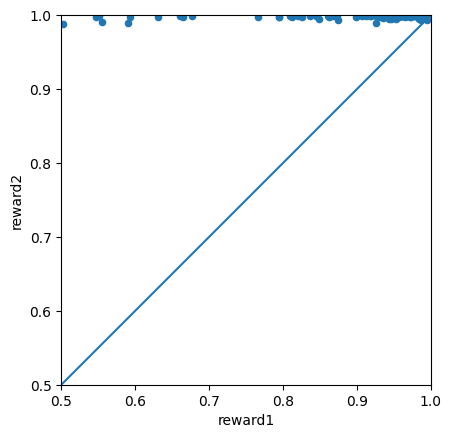

In [14]:
df.plot.scatter("reward1", "reward2")
plt.plot([0, 1], [0, 1])
plt.xlim([0.5, 1])
plt.ylim([0.5, 1])
plt.gca().set_aspect("equal")

In [15]:
df[["text1", "text2"]]

,text1,text2
0,特典 : 1. 1000円OFFクーポン 2. 1,特典も盛りだくさんで、とても満足しました。 2016年08月2
1,素晴らしいカードです。 2019年12月21日 11,素晴らしいカードです。 2014年11月23日 11
2,最早、アークティック・モンキーズは、 ロックの枠に収まらない、 ジャンル,最早、アークティック・モンキーズを代表する名盤です。 2011年リリース
3,曲良し、バンドのブルージーな演奏良し、 ボーカルの歌声良し、 曲,曲良し、バンドのブルーズも最高! 1970年発表のアルバム
4,アクションが多く、 アクションが派手で、 アクションが派手で、 アクションが派手,アクションが多く、とても面白い。 アクションゲーム初心者にもおすすめ。 ストーリーも、とても...
...,...,...
97,体の関係まで持つ同性愛のカップルは、 同性愛者同士のカップルよりも、 より,体の関係まで持つ同性愛のカップルも、とても魅力的ですよね。 同性のカップルならではの、
98,ずーっと前から、 ずーっと、 ずーっと、 ずーっと、 ずーっと、 ずーっと、,ずーっと前から欲しかったので、大満足です。 2015年03月23日
99,U2の初期リマスター盤。 1994年発表。 199,U2の初期リマスター盤で、とても聴きやすいアルバムです。 1曲目の「
100,久しぶりに見る。 2019年09月29日 10:0,久しぶりに見るけどやっぱり好き。 2014年 01月 24日


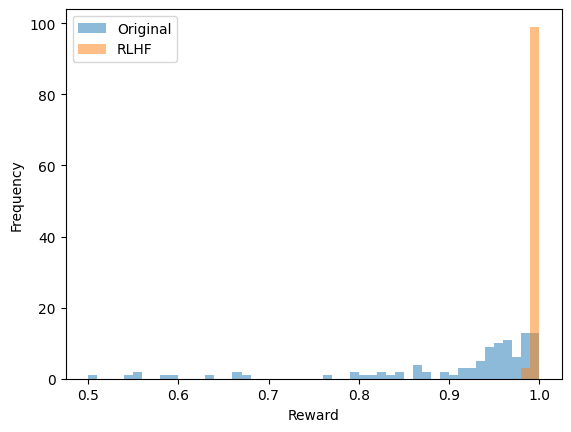

In [16]:
df["reward1"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="Original")
df["reward2"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="RLHF")
plt.gca().grid(False)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()

In [17]:
df[df["reward1"] < 0.9][["text1", "text2"]]

,text1,text2
4,アクションが多く、 アクションが派手で、 アクションが派手で、 アクションが派手,アクションが多く、とても面白い。 アクションゲーム初心者にもおすすめ。 ストーリーも、とても...
8,戦争は悪いこと。戦争はしてはいけない。 戦争はしてはいけない。 戦争はしてはいけない。,戦争は悪いこと。戦争は楽しい。そんなメッセージが伝わってくる素敵な絵本です。 絵も
9,否定的な意見を書けば「参考にならない」と批判される。 肯定的な意見を書けば「参考にならない,否定的な意見を書けば「参考」にもなるし、とても面白い。 この本は、本当にお薦めです
10,分析的な感想が多く、 分析的な感想は、 分析的な感想で、 分析,分析的な感想が多く、とても楽しく読ませていただきました。 2018年11月
12,オペラ座の怪人 2018-09-25 19,オペラも聴きごたえ十分で、大満足でした。 オペラは、ストーリーもわかりやすく、
13,ちょっとちょっと...あまりにも、あまりにも、あまりにも、あまりにも、あまりにも、あまりにも...,ちょっとちょっと...あまりにも可愛くて、思わず買ってしまいました。 一目惚れです。 一目惚...
18,1000円 1000円 1000円 1,1本でも存在感があり、とても気に入りました。
19,とんでもない。MUSEを聴いたら、もう、MUSEしか聴けない。 MUSE,とんでもない。MUSEを心から愛しています。 MUSEの楽曲は、どれも素晴らしいです
24,価格.com - ソニー SONY ウォークマン Sシリーズ 16GB NW-,価格.com で満足度の高いお買い物ができます。 2014年12月1
37,原作を読んでいないのですが、原作のストーリーはどんな感じなのでしょうか?<0x0A>,原作を読んでから読むと、さらに面白い。 原作は、2004年に出版
